In [1]:
from functools import partial
from jax import random
import jax.numpy as np
from jax.scipy.linalg import block_diag
import wandb

##s5 from https://github.com/lindermanlab/S5
from s5.train_helpers import create_train_state, reduce_lr_on_plateau,\
    linear_warmup, cosine_annealing, constant_lr, train_epoch, validate
from s5.dataloading import Datasets
from s5.seq_model import BatchClassificationModel, RetrievalModel
from s5.ssm import init_S5SSM
from s5.ssm_init import make_DPLR_HiPPO
from s5.layers import SequenceLayer
from s5.seq_model import StackedEncoderModel
import argparse
from s5.utils.util import str2bool


In [2]:
args = {
    "dir_name": './cache_dir',
    "dataset": 'mnist-classification',
    "n_layers": 6,
    "d_model": 3,
    "ssm_size_base": 256,
    "blocks": 8,
    "C_init": "trunc_standard_normal",
    "discretization": "zoh",
    "mode": "pool",
    "activation_fn": "half_glu1",
    "conj_sym": True,
    "clip_eigs": False,
    "bidirectional": False,
    "dt_min": 0.001,
    "dt_max": 0.1,
    "prenorm": True,
    "batchnorm": True,
    "bn_momentum": 0.95,
    "bsz": 64,
    "epochs": 100,
    "early_stop_patience": 1000,
    "ssm_lr_base": 1e-3,
    "lr_factor": 1,
    "dt_global": False,
    "lr_min": 0,
    "cosine_anneal": True,
    "warmup_end": 1,
    "lr_patience": 1000000,
    "reduce_factor": 1.0,
    "p_dropout": 0.0,
    "weight_decay": 0.05,
    "opt_config": "standard",
    "jax_seed": 1919
}

In [3]:


ssm_size = args["ssm_size_base"]
block_size = int(ssm_size / args["blocks"])

Lambda, _, B, V, B_orig = make_DPLR_HiPPO(block_size)
block_size = block_size // 2
ssm_size = ssm_size // 2

Lambda = Lambda[:block_size]
V = V[:, :block_size]
Vc = V.conj().T

# If initializing state matrix A as block-diagonal, put HiPPO approximation
# on each block
Lambda = (Lambda * np.ones((args["blocks"], block_size))).ravel()
V = block_diag(*([V] * args["blocks"]))
Vinv = block_diag(*([Vc] * args["blocks"]))

In [4]:
init_ssm = init_S5SSM(H=args["d_model"],
                             P=ssm_size,
                             Lambda_re_init=Lambda.real,
                             Lambda_im_init=Lambda.imag,
                             V=V,
                             Vinv=Vinv,
                             C_init=args["C_init"],
                             discretization=args["discretization"],
                             dt_min=args["dt_min"],
                             dt_max=args["dt_max"],
                             conj_sym=args["conj_sym"],
                             clip_eigs=args["clip_eigs"],
                             bidirectional=args["bidirectional"])

In [5]:
import jax


dropout = 0
rng = jax.random.PRNGKey(0)
m = 3
horizon = 100
s5_model =  StackedEncoderModel(init_ssm, d_model = args["d_model"], n_layers = args["n_layers"], training=False)
init_rng, dropout_rng = jax.random.split(rng, num=2)
variables = s5_model.init({"params": init_rng,
                        "dropout": dropout_rng},
                        np.ones((horizon, m)), integration_timesteps=None) #length x H 
    
#model = StackedEncoderModel(ssm, d_model = d_model, n_layers = 1)
#np.ones((bsz, seq_len, in_dim))

# Print the shapes of the parameters after initialization
output = s5_model.apply(variables, np.ones((horizon, m)), integration_timesteps=0)
print(output.shape)

(100, 3)


In [6]:
def s5_dyn_t(t,u,x):
    output = s5_model.apply(variables, u, integration_timesteps=0)
    return output[t]


In [7]:
from diffilqrax import ilqr, parallel_ilqr
import chex
from diffilqrax import lqr
from diffilqrax.typs import (
    iLQRParams,
    LQR,
    LQRParams,
    System,
    ParallelSystem,
    ModelDims,
    Theta,
)
from jax import Array
import jax.numpy as jnp
import jax.random as jr



In [8]:
##TODO : in parallel ilqr, pass parallel dynamics rather than serial dynamics
##also : get the gradients


##check the ability to get gradeitns

from typing import Callable, NamedTuple

def linearise(fun: Callable) -> Callable:
    """Function that finds jacobian w.r.t to x and u inputs.

    Args:
        fun (Callable): args (t, x, u, params)

    Returns:
        Callable[[Callable], Callable]): Jacobian tuple evaluated at args 1 and 2
    """
    return jax.jacrev(fun, argnums=(1, 2))


def time_map(fun: Callable) -> Callable:
    """Vectorise function in time. Assumes 0th-axis is time for x and u args of fun, the last
    arg (theta) of Callable function assumed to be time-invariant.

    Args:
        fun (Callable): function that takes args (t, x[Txn], u[Txm], theta)

    Returns:
        Callable: vectorised function along args 1 and 2 0th-axis
    """
    return jax.vmap(fun, in_axes=(0, 0, 0, None))
    # return jax.vmap(fun, in_axes=(None, 0, 0, None))
    
#(Fx, Fu) = time_map(linearise(model.dynamics))(jnp.arange(horizon), Xs[:-1], Us, theta)

##define a minis5 model and define the corresponding gradients

@jax.vmap
def binary_operator(q_i, q_j):
    """ Binary operator for parallel scan of linear recurrence. Assumes a diagonal matrix A.
        Args:
            q_i: tuple containing A_i and Bu_i at position i       (P,), (P,)
            q_j: tuple containing A_j and Bu_j at position j       (P,), (P,)
        Returns:
            new element ( A_out, Bu_out )
    """
    A_i, b_i = q_i
    A_j, b_j = q_j
    return A_j * A_i, A_j * b_i + b_j

from jax.nn.initializers import lecun_normal, normal
from s5.ssm_init import init_CV, init_VinvB, init_log_steps, trunc_standard_normal
from s5.ssm import discretize_zoh, discretize_bilinear
from flax import linen as nn
class S5Layer(NamedTuple):
    Lambda_re: jnp.ndarray
    Lambda_im: jnp.ndarray
    B_bar: jnp.ndarray
    C_tilde: jnp.ndarray
    D: jnp.ndarray
    
    # "n_layers": 6,
    # "d_model": 3,
    # "ssm_size_base": 256,
    # "blocks": 8,
    # "C_init": "trunc_standard_normal",
    # "discretization": "zoh",
    # "mode": "pool",
    # "activation_fn": "half_glu1",
    # "conj_sym": True,
    # "clip_eigs": False,
    # "bidirectional": False,
    # "dt_min": 0.001,
    # "dt_max": 0.1,
    # "prenorm": True,
    # "batchnorm": True,
    # "bn_momentum": 0.95,
    # "bsz": 64,
    # "epochs": 100,
    # "early_stop_patience": 1000,
    # "ssm_lr_base": 1e-3,
    # "lr_factor": 1,
    # "dt_global": False,
    # "lr_min": 0,
    # "cosine_anneal": True,
    # "warmup_end": 1,
    # "lr_patience": 1000000,
    # "reduce_factor": 1.0,
    # "p_dropout": 0.0,
    # "weight_decay": 0.05,
    # "opt_config": "standard",
    # "jax_seed": 1919
class S5Model(nn.Module):
    def __init__(self, num_layers):
        self.s5_model = s5_model
        # self.variables = model.init({"params": init_rng,
        #                     "dropout": dropout_rng},
        #                    dummy_input, integration_timesteps,
        #                    )
        self.num_layers = num_layers 
        self.conj_sym = False
        self.clip_eigs = True
        self.blocks = 8
        self.H= 16 #d_model,
        self.P= 32 #ssm_size,
        self.blocks = num_layers#default = 2 blocks
        self.discretization = "zoh"
        self.key = 4
        self.dt_min = 0.001
        self.dt_max = 0.1
        self.layer_params = None
        self.lr = 0.001
        self.step_rescale = 1.0
        self.zero_im = True
        ##for now do it with 2 layers, then will actually use the flax stuff
        
    def initialize_layer(self,key):
        ssm_size = self.P
        # determine the size of initial blocks
        block_size = int(ssm_size / self.blocks)
        Lambda, _, B, V, B_orig = make_DPLR_HiPPO(block_size)
        Lambda = Lambda[:block_size]
        V = V[:, :block_size]
        Vc = V.conj().T
        Lambda = (Lambda * np.ones((self.blocks, block_size))).ravel()
        V = block_diag(*([V] * self.blocks))
        Vinv = block_diag(*([Vc] * self.blocks))
        """Initializes parameters once and performs discretization each time
           the SSM is applied to a sequence
           Dierctly taken from the S5 repo https://github.com/lindermanlab/S5/tree/main/s5
        """

        if self.conj_sym:
            # Need to account for case where we actually sample real B and C, and then multiply
            # by the half sized Vinv and possibly V
            local_P = 2*self.P
        else:
            local_P = self.P

        # Initialize diagonal state to state matrix Lambda (eigenvalues)
        Lambda_re = Lambda.real
        if self.zero_im :
            Lambda_im = np.zeros_like(Lambda_re)
        else : 
            Lambda_im = Lambda.imag
        if self.clip_eigs:
            Lambda = np.clip(Lambda_re, None, -1e-4) + 1j * Lambda_im
        else:
            Lambda = Lambda_re + 1j * Lambda_im

        # Initialize input to state (B) matrix
        B_init = lecun_normal()
        B_shape = (local_P, self.H)
        key, subkey = jr.split(key)
        B = init_VinvB(B_init, subkey, B_shape, Vinv)
        #self.param("B",
                  #          lambda rng, shape: init_VinvB(B_init,
                         #                                 rng,
                       #                                   shape,
                         #                                 self.Vinv),
                          #  B_shape)
        B_tilde =  B[..., 0] + 1j * B[..., 1]
        #C_init = normal(stddev=0.5 ** 0.5)
        key, subkey = jr.split(key)
        C = jr.normal(key, shape =  (self.H, self.P, 2))
        #C = self.param("C", C_init, (self.H, 2 * self.P, 2))
        C_tilde = C[..., 0] + 1j * C[..., 1]

        # Initialize feedthrough (D) matrix
        key, subkey = jr.split(subkey)
        D = jr.normal(key, shape = (self.H,))
        #self.param("D", normal(stddev=1.0), (self.H,))

        # Initialize learnable discretization timescale value
        log_step = jnp.linspace(self.dt_min, self.dt_max, self.P)
        #self.param("log_step",
                               #    init_log_steps,
                               #    (self.P, self.dt_min, self.dt_max))
        step = self.step_rescale * np.exp(log_step)

        # Discretize
        if self.discretization in ["zoh"]:
            Lambda_bar, B_bar = discretize_zoh(Lambda, B_tilde, step)
        elif self.discretization in ["bilinear"]:
            Lambda_bar, B_bar = discretize_bilinear(Lambda, B_tilde, step)
        else:
            raise NotImplementedError("Discretization method {} not implemented".format(self.discretization))
        return S5Layer(Lambda_re = Lambda_re, Lambda_im = Lambda_im, B_bar = B_bar, C_tilde = C_tilde, D = D)

    def initialize_params(self, key):
        keys = jax.random.split(key, self.num_layers) ##need to put the lengths somewhere but for now fixed
        self.layer_params = [self.initialize_layer(k) for k in keys] 
    
    def apply_single_layer_full(self, layer_params, input_sequence):
        Lambda_bar = layer_params.Lambda_re + 1j * layer_params.Lambda_im
        Lambda_elements = Lambda_bar * np.ones((input_sequence.shape[0],
                                                Lambda_bar.shape[0]))
        Bu_elements = jax.vmap(lambda u: layer_params.B_bar @ u)(input_sequence)

        _, xs = jax.lax.associative_scan(binary_operator, (Lambda_elements, Bu_elements))
        ##other optiosn : birectional, conj sym -> not using those yet
        return jax.vmap(lambda x: (layer_params.C_tilde @ x).real)(xs), xs
    
    def apply_single_layer_step(self, layer_params, xl_t, ul_t):
        Lambda_bar = layer_params.Lambda_re + 1j * layer_params.Lambda_im
        nx = Lambda_bar * xl_t + layer_params.B_bar @ ul_t
        otpt = layer_params.C_tilde @ nx
        #_, xs = jax.lax.associative_scan(binary_operator, (Lambda_elements, Bu_elements))
        ##other optiosn : birectional, conj sym -> not using those yet
        return nx, otpt.real
    
    def single_s5_step(self, xs_t, u0_t):
        ##go through the layers
        u = u0_t
        nxs = []
        for i, layer_prms in enumerate(self.layer_params):
            x = xs_t[i*self.P:(i+1)*self.P]
            nx, o = self.apply_single_layer_step(layer_prms, x, u)
            nxs.append(nx)
            u = o
        return jnp.concatenate(nxs), u
    
    def apply_full(self, us):
        ##go through the layers
        u = us
        nxs = []
        for layer_prms in self.layer_params:
            u, nx = self.apply_single_layer_full(layer_prms, u)
            nxs.append(nx)
        print(nxs[0].shape)
        return jnp.concatenate(nxs, axis = 1), u
        
s5model = S5Model(num_layers = 2)
s5model.initialize_params(key = jax.random.PRNGKey(2))
##in the checks, will need to check that the output of the parallel and sequential rollouts are the same

(100, 32)


/Users/marineschimel/.virtualenvs/diffusion/lib/python3.11/site-packages/jax/_src/lax/lax.py:2740: ComplexWarning: Casting complex values to real discards the imaginary part
  x_bar = _convert_element_type(x_bar, x.aval.dtype, x.aval.weak_type)
/Users/marineschimel/.virtualenvs/diffusion/lib/python3.11/site-packages/jax/_src/lax/lax.py:2740: ComplexWarning: Casting complex values to real discards the imaginary part
  x_bar = _convert_element_type(x_bar, x.aval.dtype, x.aval.weak_type)


(100, 32)


/Users/marineschimel/.virtualenvs/diffusion/lib/python3.11/site-packages/jax/_src/lax/lax.py:2740: ComplexWarning: Casting complex values to real discards the imaginary part
  x_bar = _convert_element_type(x_bar, x.aval.dtype, x.aval.weak_type)
/Users/marineschimel/.virtualenvs/diffusion/lib/python3.11/site-packages/jax/_src/lax/lax.py:2740: ComplexWarning: Casting complex values to real discards the imaginary part
  x_bar = _convert_element_type(x_bar, x.aval.dtype, x.aval.weak_type)
/Users/marineschimel/.virtualenvs/diffusion/lib/python3.11/site-packages/jax/_src/lax/lax.py:2740: ComplexWarning: Casting complex values to real discards the imaginary part
  x_bar = _convert_element_type(x_bar, x.aval.dtype, x.aval.weak_type)


(100, 32)
(100, 32)


/Users/marineschimel/.virtualenvs/diffusion/lib/python3.11/site-packages/jax/_src/lax/lax.py:2740: ComplexWarning: Casting complex values to real discards the imaginary part
  x_bar = _convert_element_type(x_bar, x.aval.dtype, x.aval.weak_type)
/Users/marineschimel/.virtualenvs/diffusion/lib/python3.11/site-packages/jax/_src/lax/lax.py:2740: ComplexWarning: Casting complex values to real discards the imaginary part
  x_bar = _convert_element_type(x_bar, x.aval.dtype, x.aval.weak_type)


(100, 32)


/Users/marineschimel/.virtualenvs/diffusion/lib/python3.11/site-packages/jax/_src/lax/lax.py:2740: ComplexWarning: Casting complex values to real discards the imaginary part
  x_bar = _convert_element_type(x_bar, x.aval.dtype, x.aval.weak_type)


(100, 32)


/Users/marineschimel/.virtualenvs/diffusion/lib/python3.11/site-packages/jax/_src/lax/lax.py:2740: ComplexWarning: Casting complex values to real discards the imaginary part
  x_bar = _convert_element_type(x_bar, x.aval.dtype, x.aval.weak_type)
/Users/marineschimel/.virtualenvs/diffusion/lib/python3.11/site-packages/jax/_src/lax/lax.py:2740: ComplexWarning: Casting complex values to real discards the imaginary part
  x_bar = _convert_element_type(x_bar, x.aval.dtype, x.aval.weak_type)
/Users/marineschimel/.virtualenvs/diffusion/lib/python3.11/site-packages/jax/_src/lax/lax.py:2740: ComplexWarning: Casting complex values to real discards the imaginary part
  x_bar = _convert_element_type(x_bar, x.aval.dtype, x.aval.weak_type)


(100, 32)
(100, 32)


/Users/marineschimel/.virtualenvs/diffusion/lib/python3.11/site-packages/jax/_src/lax/lax.py:2740: ComplexWarning: Casting complex values to real discards the imaginary part
  x_bar = _convert_element_type(x_bar, x.aval.dtype, x.aval.weak_type)


(100, 32)
(100, 32)


/Users/marineschimel/.virtualenvs/diffusion/lib/python3.11/site-packages/jax/_src/lax/lax.py:2740: ComplexWarning: Casting complex values to real discards the imaginary part
  x_bar = _convert_element_type(x_bar, x.aval.dtype, x.aval.weak_type)
/Users/marineschimel/.virtualenvs/diffusion/lib/python3.11/site-packages/jax/_src/lax/lax.py:2740: ComplexWarning: Casting complex values to real discards the imaginary part
  x_bar = _convert_element_type(x_bar, x.aval.dtype, x.aval.weak_type)


(100, 32)
Converged in 4/80 iterations
old_cost: 5855.776995366822


/Users/marineschimel/.virtualenvs/diffusion/lib/python3.11/site-packages/jax/_src/lax/lax.py:2740: ComplexWarning: Casting complex values to real discards the imaginary part
  x_bar = _convert_element_type(x_bar, x.aval.dtype, x.aval.weak_type)


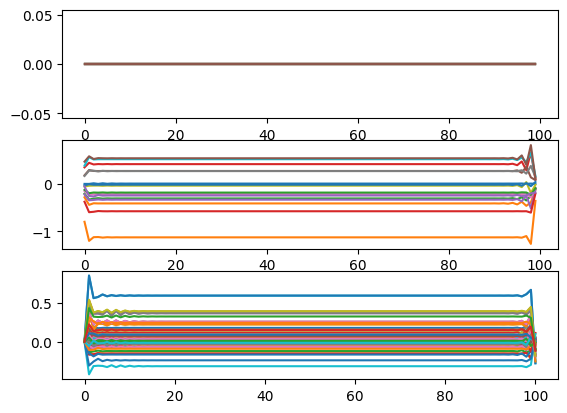

In [9]:
dt = 0.1
Uh = jnp.array([[1, dt], [-1 * dt, 1 - 0.5 * dt]])
Wh = jnp.eye(3)*dt #jnp.array([[0, 0,1], [1, 0]]) * dt
Q = jnp.eye(2)
key = jr.PRNGKey(0)
# initialise params
theta = Theta(Uh=Uh, Wh=Wh, sigma=jnp.zeros((2)), Q=Q)
params = iLQRParams(x0=jnp.zeros(2*s5model.P), theta=theta)
x_tgt = jnp.ones(2*s5model.P)
def cost(t: int, x: Array, u: Array, theta: Theta):
    return jnp.sum((x.squeeze() - x_tgt.squeeze())**2) + jnp.sum(u**2)

def costf(x: Array, theta: Theta):
    # return jnp.sum(jnp.abs(x))
    return jnp.sum(x**2)

def dynamics(t: int, x: Array, u: Array, theta: Theta):
    nx, _ = s5model.single_s5_step(x, u)
    return nx.real
def parallel_dynamics(us, theta):
    xs, os = s5model.apply_full(us)
    return xs.real
m = s5model.H
model = ParallelSystem(
    cost, costf, dynamics, parallel_dynamics, ModelDims(horizon=100, n=2*s5model.P, m=m, dt=dt)
)

dims = chex.Dimensions(T=horizon, N=2*s5model.P, M=s5model.H, X=1)
Us_init = 0.0 * jr.normal(
    key, (model.dims.horizon, s5model.H)
)
# define model




# define linesearch parameters
ls_kwargs = {
"beta": 0.8,
"max_iter_linesearch": 5,
"tol": 1e-5,
"alpha_min": 0.0001,
}
# nxs, output = s5model.full_s5_step(Us_init)
# print(nxs[1].shape)
# x0 = [jnp.zeros(s5model.P) for _ in range(s5model.num_layers)]
# nx, o = s5model.single_s5_step(jnp.concatenate(x0), Us_init[0])

#(Xs_init, _), _= parallel_ilqr.ilqr_simulate(model, Us_init, params)
(Xs_stars, Us_stars, Lambs_stars), total_cost, cost_log = parallel_ilqr.pilqr_solver(
            model,
            params,
            Us_init,
            max_iter=80,
            convergence_thresh=1e-13,
            alpha_init=1.,
            verbose=True,
            use_linesearch=True,
            **ls_kwargs,
        )

from matplotlib import pyplot as plt
fig, axes = plt.subplots(3,1)
axes[0].plot(Us_init)
axes[1].plot(Us_stars)
axes[2].plot(Xs_stars)

##still need to edit the dJ/dj
##need to pass both the parallel dynamics and the non parallel dynamics 

(15, 32)


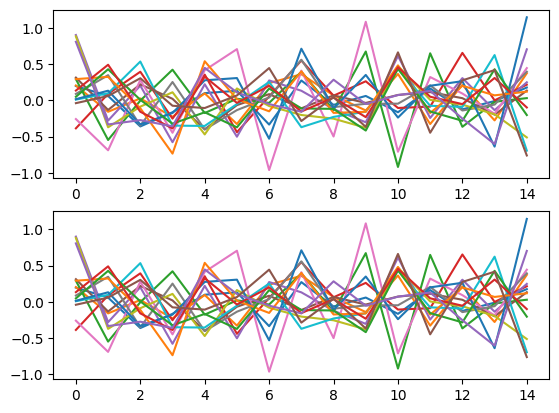

In [10]:
def test_s5_model():
    # Initialize the model
    model = S5Model(num_layers=1)
    key = jax.random.PRNGKey(0)
    model.initialize_params(key)

    # Generate a random input sequence
    input_sequence = 0.1*jax.random.normal(key, (15, model.H))

    # Apply the model to the input sequence using apply_full
    _, output_full = model.apply_full(input_sequence)

    # Apply the model to the input sequence using lax.scan
    xs_t = jnp.zeros((model.num_layers*model.P,))
    _, output_scan = jax.lax.scan(model.single_s5_step, xs_t, input_sequence)
    # def single_step(x, u):
    #     nx = model.apply_single_layer_step(model.layer_params[0], x, u)[0]
    #     print("cat")
    #     return nx, nx
    # _, output_scan = jax.lax.scan(single_step, jnp.zeros((model.P,)), input_sequence)

    # Check that the outputs are close
    fig, axes = plt.subplots(2, 1)
    axes[0].plot(output_full)
    axes[1].plot(output_scan)
    assert jnp.allclose(output_full, output_scan), "Outputs do not match"

test_s5_model()